In [2]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
import pystan
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 50)
from sqlalchemy import create_engine
import psycopg2 as pq
golf_db = 'postgresql://localhost:5432/golf'


In [4]:
def scale_plot_size(factor=1.5):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor
    
def exec_sql(sqlTxt, result=False):  
    with pq.connect(golf_db) as conn:
        with conn.cursor() as cursor:
            cursor.execute(sqlTxt) 
            if result:
                return [row for row in cursor] 
        
def pd_from_sql(sqlTxt):
    with pq.connect(golf_db) as conn:
        return pd.read_sql_query(sqlTxt, conn)
    
def np_to_sql(arr, table):
    df = pd.DataFrame(arr)
    with pq.connect(golf_db) as conn:
        df.to_sql(table, conn, if_exists='append')
        
def np_from_sql(sqlTxt):
    return pd_from_sql(sqlTxt).as_matrix()

In [103]:
sqlTxt = '''
select * from (select year, player_id, row_number from rank_view where year = 2014  limit 100) r 
    join scores_view s 
    using (player_id, year) order by r.row_number, player_id, year, permanent_tournament_id, round;
'''
scores = pd_from_sql(sqlTxt)
num_scores = len (scores)
scores.columns 

Index([u'player_id', u'year', u'row_number', u'date',
       u'permanent_tournament_id', u'round', u'score'],
      dtype='object')

In [104]:
player_ids = scores['player_id'].unique()
num_players = len (player_ids)
player_map = dict(zip(player_ids, range(1,num_players + 1)))
tournament_ids = scores['permanent_tournament_id'].unique()
num_tournaments = len (tournament_ids)
tournament_map = dict(zip(tournament_ids, range(1, num_tournaments + 1)))

In [105]:
datum = sorted([[player_map[i[0]], tournament_map[i[4]], i[6]] for i in scores.as_matrix()], key = lambda (el): el[0])
p, t, y = zip(*datum)
rounds = np.zeros([100])
for s in p:
    rounds[s-1] += 1
rounds = rounds.tolist()

In [112]:
code = """
data {
  int N;
  int N_P;
  int N_T;
  int y[N];
  int p[N];
  int t[N];
  real rounds[N_P];
}
# Trending Model
parameters {
  real alpha[N_T];
  real<lower=0, upper=7> sigma[N_P];
  real<lower=65, upper=75> tau[N_P];
  real<lower=-2, upper=2> beta[N_P];
} 
model {
  real trend = 0;
  real m = 1;
  real scale = 1.0/70.0;  #  average score
  alpha ~ normal(0, 1);
  y[1] ~ normal(alpha[t[1]] + tau[p[1]], sigma[p[1]]);
  for (n in 2:N) {
    if (p[n] != p[n-1])
      m = n;
    trend = 1 - beta[p[n]]*scale/2 + beta[p[n]]*(n-m)*scale/rounds[p[n]];
    y[n] ~ normal(alpha[t[n]] + tau[p[n]]*trend, sigma[p[n]]);
    
  } 
}

"""
data = {
    'N': num_scores,
    'y': y,
    'p' : p,
    't' : t,
    'N_P' : num_players,
    'N_T' : num_tournaments,
    'rounds' : rounds
}

fit = pystan.stan(model_code=code, data=data, iter=1000, chains=4)
means = fit.get_posterior_mean()
print fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_98f721a77cf8f6b0c5e5fe95e7b9556e NOW.


Inference for Stan model: anon_model_98f721a77cf8f6b0c5e5fe95e7b9556e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]   -2.02    0.02   0.27  -2.56   -2.2  -2.02  -1.83  -1.49  236.0   1.02
alpha[1]    1.87    0.02   0.28   1.31   1.69   1.88   2.05   2.42  246.0   1.02
alpha[2]    -0.4    0.02   0.27  -0.92  -0.57  -0.41  -0.23   0.14  218.0   1.02
alpha[3]    1.73    0.02   0.25   1.24   1.57   1.74    1.9   2.23  184.0   1.03
alpha[4]   -0.05  8.4e-3   0.38  -0.76  -0.31  -0.05   0.21   0.68 2000.0   1.01
alpha[5]    -0.7    0.02   0.24  -1.19  -0.85   -0.7  -0.55  -0.21  196.0   1.02
alpha[6]    1.36    0.02   0.25   0.87   1.19   1.36   1.52   1.84  191.0   1.02
alpha[7]    0.18    0.02   0.23  -0.28   0.03   0.18   0.34   0.64  160.0   1.02
alpha[8]   -0.29    0.02   0.25  -0.81  -0.46  -0.29  -0.12   0.19  205.0   1.02
alp

-0.256315789474
3.12 3.37238237256


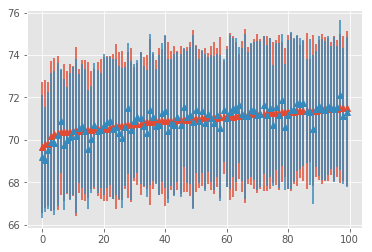

In [113]:
print offset
offset = np.mean([round(means[i][0],2) for i in range(0,num_tournaments)])
avg_score = [round(means[i][0],2) for i in range(num_tournaments+num_players,num_tournaments+2*num_players)]
std_score = [round(means[i][0],2) for i in range(num_tournaments,num_tournaments+num_players)]
sqlTxt = '''
select * from stats_view where year = 2014 limit 100; 
'''
df = pd_from_sql(sqlTxt)
foo = plt.errorbar(range(0, num_players), df['avg_score'], df['std_score'], linestyle='None', marker='^')
foo = plt.errorbar(range(0, num_players), avg_score + offset, std_score, linestyle='None', marker='^')
print np.mean(std_score), np.mean(df['std_score']) 
